# Deep Learning Wall Detector

#### The objective is try out Image-Segmentation on a dataset <br>outside the usual ones like CamVid.

#### The data consists of French house plans from the planning<br>office and the wall masks have been prepared by the creators.

#### Let us see if we can train a high accuracy Deep Learning <br> image segmentor which can extract only the wall features off<br<br> the scans of the plans.

#### The dataset can be found here:
http://dag.cvc.uab.es/resources/floorplans/

#### Dataset citation
Authors: de las Heras, Lluis-Pere and Terrades, OriolRamos and Robles, Sergi and Sanchez, Gemma<br>
Title: CVC-FP and SGT: a new database for structural floor plan analysis and its groundtruthing tool<br>
Journal: International Journal on Document Analysis and Recognition, 2015<br>

### Imports and magics

In [1]:
from fastai.vision import *

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

### Set paths

In [4]:
path = Path('.')
data_path = path/'data'

In [5]:
data_path.ls()

[PosixPath('data/wallmasks'),
 PosixPath('data/images'),
 PosixPath('data/walllabels')]

In [6]:
image_path = data_path/'images'
mask_path = data_path/'walllabels'

### Check contents

In [7]:
#same length
print(len(image_path.ls()))
print(len(mask_path.ls()))

122
122


In [9]:
image_path.ls()[0:3]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png')]

In [10]:
mask_path.ls()[0:3]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png')]

### Create lists of images and masks

In [11]:
image_list = get_image_files(image_path)
type(image_list)

list

In [12]:
image_list[0:3]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png')]

In [14]:
mask_list = get_image_files(mask_path)

In [15]:
mask_list[0:3]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png')]

### View file contents

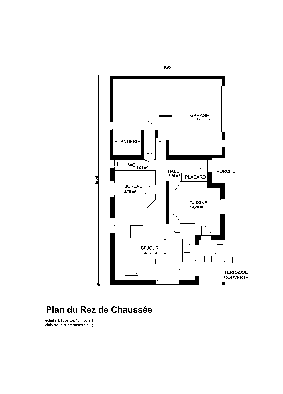

In [17]:
open_image(image_list[0]).show(figsize=(7,7))

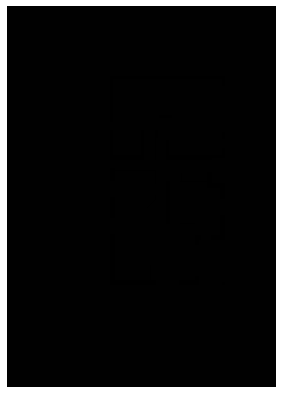

In [19]:
open_image(mask_list[0]).show(figsize=(7,7))

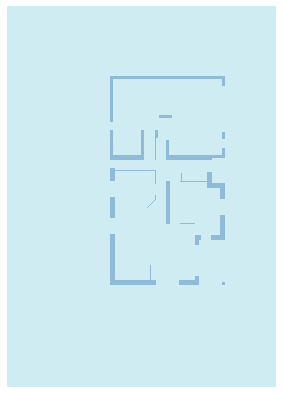

In [20]:
#it seems mask is not a standard image file
#luckily fastai provides a convenient function to view masks

open_mask(mask_list[0]).show(figsize=(7,7))

In [21]:
#fyi - mask is rank 3 pytorch tensor 1 channel deep

sample_mask = open_mask(mask_list[0])
sample_mask.shape

torch.Size([1, 3508, 2479])

### Create fastai data object with all data

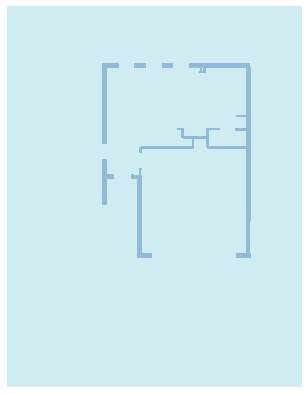

In [23]:
#To begin we require a way to tell the learner how to find the masks
#we can pass it a function which navigates from image file to mask file.

#We can crete a lambda which uses python's pathlib
path_func_image_to_mask = lambda x: mask_path/f'{x.stem}{x.suffix}'

#let test it, should return the relevant mask
retrieved_mask = path_func_image_to_mask(image_list[120])
open_mask(retrieved_mask).show(figsize=(7,7))

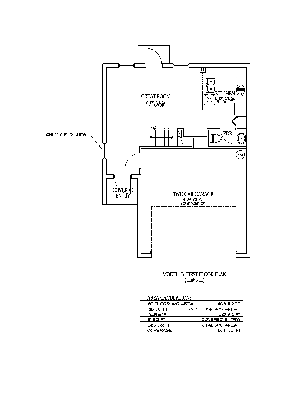

In [26]:
#compare to the orginal image by eye
open_image(image_list[120]).show(figsize=(7,7))

In [27]:
#Fastai uses objects to track what data we are using.
#We reserve 30% as validation set as the dataset is small.

seg_list = (SegmentationItemList
            .from_folder(image_path)
            .split_by_rand_pct(0.3, seed=99)
            .label_from_func(path_func_image_to_mask, classes=['wall', 'notawall'])
           )

In [29]:
#let us double check the resulting object

print(type(seg_list), '\n', '_ '*20, '\n')
#seg_list

<class 'fastai.data_block.LabelLists'> 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  



In [32]:
#Transforms modify the data to aid with learning
#Let us view the standard hyper-parameters.

default_tfms = get_transforms()
#default_tfms


In [33]:
#Let me see if I can use my intuition to better adapt the
#transforms to the dataset.

my_tfms = get_transforms(rotate(p=0), 
                         zoom(scale=(1.2, 1.2))
                         )                                   
                                    

In [35]:
#batch size is used to control gpu memory usage.

batch_size=6

In [36]:
#A databunch ties together the data and validation set, transforms
#and normalizes in a manner suitable for transfer learning.

databunch = (seg_list.transform(default_tfms, size=896, tfm_y=True)
            .databunch(bs=batch_size).normalize(imagenet_stats))
type(databunch)

fastai.vision.data.ImageDataBunch

In [38]:
#review for reasonableness

#databunch

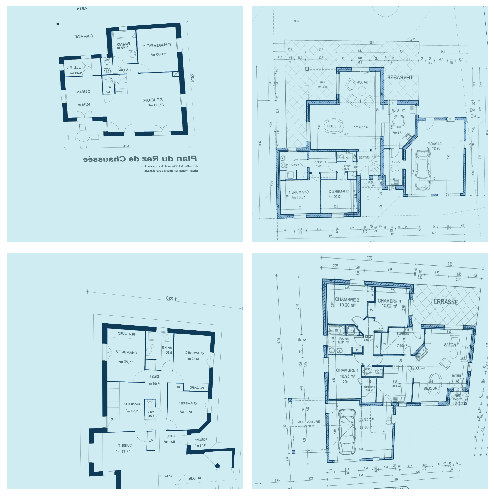

In [40]:
databunch.show_batch(2, figsize=(7,7))

### Create model

In [41]:
#weight decay - around 0.1 is (anecdotally) tested by fastai 
#be ideal for almost all datasets. The standard default of 0.01
#is very conservative.

wd=1e-1

In [43]:
#Dice is the standard metric for segmentation.
#We can speed up training using fp16
#Let us try resnet 18 and resnet 34.

#learner = unet_learner(databunch, models.resnet34, metrics=dice, wd=wd).to_fp16()
learner = unet_learner(databunch, models.resnet18, metrics=dice, wd=wd).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


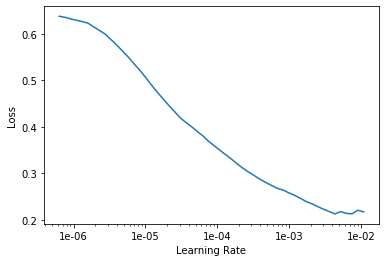

In [44]:
#plotting learning rate vs. error rate allows us to better
#set the initial learning rate. A good heuristic is to find
#the steepest part of the descending curve.

lr_find(learner)
learner.recorder.plot()

### Initial Training

In [45]:
#By inspection of the graph above we should start
#around 5e-5

learner.fit_one_cycle(5, 5e-05)

epoch,train_loss,valid_loss,dice,time
0,0.336764,0.138139,0.980700,00:52
1,0.190761,0.072705,0.990121,00:47
2,0.130909,0.053918,0.991152,00:50
3,0.099711,0.050113,0.991435,00:51
4,0.080928,0.047549,0.991463,00:52


In [46]:
#Judging by train vs validation loss
#we can afford a higher learning rate.

learner.fit_one_cycle(5, 5e-04)

epoch,train_loss,valid_loss,dice,time
0,0.048304,0.044628,0.992716,00:49
1,0.049307,0.044914,0.992740,00:48
2,0.051808,0.038903,0.992158,00:47
3,0.042998,0.029682,0.994072,00:49
4,0.036612,0.029742,0.994484,00:53


In [ ]:
#learner.save('Basic Training')

### Fine Tuning

In [47]:
#The learner crashes here the GPU cache is not clearing
#properly. Manual garbage collection seems to help.
#Using GCP (Google Cloud) with a 24GB ram gpu.
gc.collect()

6259

In [ ]:
#Reload the learner if garbage collection not working.
#learner.load('Basic Training')

In [48]:
#unfreeze the pretrained weights
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


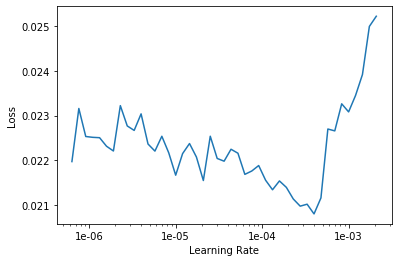

In [49]:
lr_find(learner)
learner.recorder.plot()

In [50]:
lr = slice(1e-04, 1e-04/3)

In [51]:
learner.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,dice,time
0,0.020501,0.028837,0.994712,00:54
1,0.020621,0.029474,0.994921,00:53
2,0.020270,0.033374,0.994376,00:49
3,0.018671,0.026268,0.995681,00:54
4,0.017594,0.023587,0.995938,00:49
5,0.016648,0.023350,0.996072,00:51
6,0.015914,0.024368,0.996060,00:53
7,0.015247,0.024129,0.996074,00:52


In [52]:
#note, the highest dice is the same 99.61 between
#using resnet 34 and 32 bit accuracy and using
#resnet 18 and 16 bit accuracy. I do note that
#somewhat counterintuitively the latter takes
#a few seconds longer per epoque.

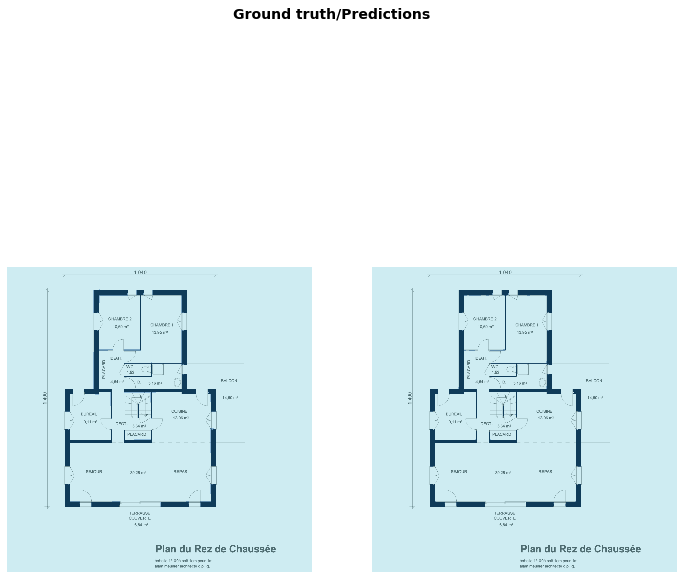

In [54]:
learner.show_results(rows=1, figsize=(12,12))

### Conclusion: 

The final result is seemingly of high quality at 99.6%<br>
accuracy of detected pixels. I suspect it would be<br>
difficult to (superficially) spot these differences<br>
if the model was used in practice. It would be<br>
preferable to compare to objective results but<br>
refretaably none to be published online.